# Machine learning for ptychographic reconstruction

In this notebook we explore using neural networks for ptychographic phase retrieval. 

Essentially, instead of iteratively conducting optimization on the object/probe, we train a CNN to directly predict the phase from diffraction patterns.

We compare supervised learning (train on simulated data with known ground truth) and physics-informed learning (use the forward model as a constraint during training). We also compare the speed differences -- neural network inference time vs iterative reconstruction time.

### Downloads

- [MoS2 twisted bilayer 4D-STEM dataset at bin 2](https://drive.google.com/file/d/1C3tXV5BXz0JXbmyu3wTu3NutuIYYsN8A/view?usp=sharing)

### Acknowledgements

The 4D-STEM dataset was recorded by Zhen Chen in the Muller group at Cornell University.  
See: [Electron ptychography of 2D materials to deep sub-angstrom resolution](https://doi.org/10.1038/s41586-018-0298-5)

2026 Jan 5

## Why ML

Traditional ptycho reconstruction uses iterative algorithms like ePIE or gradient descent, which work well but are slow since ech reconstruction requires hundreds of iterations.

Neural networks offer a different approach through amortized inference. We invest time upfront to train a network then get fast reconstructions for our inferences. This is useful for real time imaging and large dataset processing.

This works because ptycho is essentially an inverse problem. The mapping that takes place from diffraction patterns to phase images has patterns that a neural network can learn.

In [28]:
# Fix NumPy compatibility

import numpy as np
import os

if int(np.__version__.split('.')[0]) >= 2:
    %pip install "numpy<2" > /dev/null 2>&1
    os._exit(0)


In [29]:
# Imports

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import py4DSTEM

print(py4DSTEM.__version__)

0.14.16


In [30]:
# Device setup

device = 'gpu'
torch_device = torch.device('cuda')
torch.cuda.empty_cache() # clear cache to avoid mem error

print(f"device: {device}")

device: gpu


## Load the MoS2 dataset

In [31]:
# Download the 4DSTEM dataset

py4DSTEM.io.gdrive_download(
    id_ = 'https://drive.google.com/uc?id=1C3tXV5BXz0JXbmyu3wTu3NutuIYYsN8A',
    destination = './',
    filename = 'ptycho_MoS2_bin2.h5',
    overwrite = False,
)

A file already exists at ./ptycho_MoS2_bin2.h5, skipping...


In [32]:
# Load dataset

dataset = py4DSTEM.read('./ptycho_MoS2_bin2.h5')
dataset.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:      3.2990832213275603
             R_pixel_size:      0.59
             Q_pixel_units:     mrad
             R_pixel_units:     A
             QR_flip:           False
             probe_semiangle:   6.486650552388484
             qx0_mean:          29.287584419369598
             qy0_mean:          30.34295690657806
)

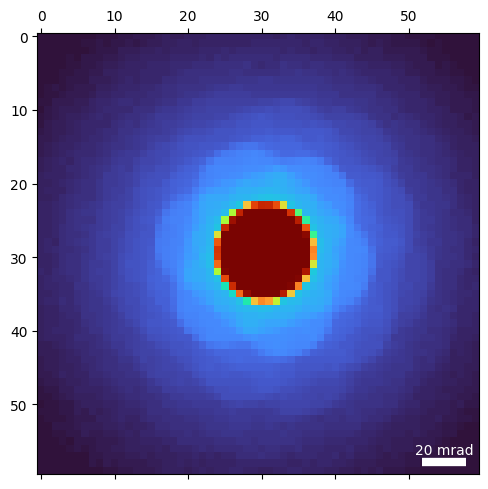

In [33]:
# Mean diffraction pattern

dataset.get_dp_mean();

py4DSTEM.show(
    dataset.tree('dp_mean'),
    power = 0.25,
    cmap = 'turbo',
)

## physics setup

We need the electron wavelength and other parameters for the forward model. At 80 keV, electrons travel at relativistic speeds so we use the relativistic de Broglie formula

In [34]:
# Physical constants

electron_mass = 9.109e-31
electron_charge = 1.602e-19
planck = 6.626e-34
rest_energy_keV = 511.0

def get_wavelength(voltage_kev):
    """relativistic electron wavelength in nm"""
    V = voltage_kev * 1e3
    E0 = rest_energy_keV * 1e3
    factor = 1 + V / (2 * E0)
    lam = planck / np.sqrt(2 * electron_mass * electron_charge * V * factor)
    return lam * 1e9

wavelength = get_wavelength(80)
print(f"wavelength at 80kV: {wavelength:.5f} nm")

wavelength at 80kV: 0.00418 nm


In [35]:
# Config

object_size = 128 
probe_size = 48    
diffraction_size = 60
pixel_size = 0.059  # nm
convergence_angle = 0.0214
scan_step = 12 

## PtychoNN

While ptychography traditionally solves a nonlinear inverse problem with iterations PtychoNN instead uses a neural network to learn that inversion.

PtychoNN (ptychographic neural network) is a U-Net style architecture (mapping one img --> another img) that takes a diffraction pattern as input and outputs amplitude and phase images in real space. 

The encoder progressively applies convolutions and learns local patterns like rings and asymmetries while also applying pooling.

The decoder then takes those compressed, abstract features and "upsamples" them back to full res. But this is difficult because pooling destroys details like sharp edges, atomic scale phase gradients.

As a result, we need skip connections. They copy encoder feature maps directly into the decoder, minimizing loss of information.

PtychoNN also has "two heads" for outputs, one for amplitude and another for phase. This is because they have different statistics and converge @ different rates.

In [36]:
# Model blocks


def _make_gn(ch, max_groups=8):
    groups = min(max_groups, ch)
    while ch % groups != 0:
        groups -= 1
    return nn.GroupNorm(groups, ch)


class ConvBlock(nn.Module):
    """Lightweight conv block with GN + SiLU and optional residual."""
    def __init__(self, in_ch, out_ch, dropout=0.0, use_residual=True):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm1 = _make_gn(out_ch)
        self.act = nn.SiLU(inplace=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm2 = _make_gn(out_ch)
        self.drop = nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()
        self.use_residual = use_residual and in_ch == out_ch

    def forward(self, x):
        out = self.act(self.norm1(self.conv1(x)))
        out = self.drop(out)
        out = self.act(self.norm2(self.conv2(out)))
        if self.use_residual:
            out = out + x
        return out


class EncoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0):
        super().__init__()
        self.block = ConvBlock(in_ch, out_ch, dropout=dropout)
        self.down = nn.Conv2d(out_ch, out_ch, 3, stride=2, padding=1)

    def forward(self, x):
        features = self.block(x)
        pooled = self.down(features)
        return pooled, features


class DecoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.reduce = nn.Conv2d(in_ch, out_ch, 1)
        self.block = ConvBlock(out_ch * 2, out_ch, dropout=dropout, use_residual=False)

    def forward(self, x, skip):
        x = self.up(x)
        x = self.reduce(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)
        return self.block(x)


In [37]:
# Model: encoder-decoder ptychography network


class PtychoNN(nn.Module):
    """Encoder-decoder network for ptychography phase retrieval.

    Input: stack of diffraction patterns [B, N_scan, H, W]
    Output: amplitude + phase [B, 1, H_obj, W_obj]
    """
    def __init__(self, n_scan_positions, base_ch=32, depth=3, obj_size=128, dropout=0.0):
        super().__init__()
        self.n_scan = n_scan_positions
        self.obj_size = obj_size

        channels = [base_ch * (2**i) for i in range(depth + 1)]

        self.input_conv = nn.Conv2d(n_scan_positions, base_ch, 3, padding=1)

        self.encoders = nn.ModuleList()
        in_ch = base_ch
        for i in range(depth):
            self.encoders.append(EncoderBlock(in_ch, channels[i], dropout=dropout))
            in_ch = channels[i]

        self.bottleneck = ConvBlock(channels[depth-1], channels[depth], dropout=dropout)

        self.decoders = nn.ModuleList()
        for i in range(depth-1, -1, -1):
            self.decoders.append(DecoderBlock(channels[i+1], channels[i], dropout=dropout))

        self.upsample = nn.Upsample(size=(obj_size, obj_size), mode='bilinear', align_corners=False)
        self.head = nn.Sequential(
            nn.Conv2d(channels[0], channels[0], 3, padding=1),
            nn.SiLU(inplace=True),
        )
        self.out = nn.Conv2d(channels[0], 2, 1)

    def forward(self, x):
        x = self.input_conv(x)

        skips = []
        for enc in self.encoders:
            x, skip = enc(x)
            skips.append(skip)

        x = self.bottleneck(x)

        for i, dec in enumerate(self.decoders):
            x = dec(x, skips[-(i+1)])

        x = self.upsample(x)
        x = self.head(x)
        out = self.out(x)

        amplitude = torch.sigmoid(out[:, :1])
        phase = torch.tanh(out[:, 1:2]) * np.pi
        return amplitude, phase


In [38]:
# Compute scan grid and sanity check the model

n_scan_1d = (object_size - probe_size) // scan_step + 1
n_scan_positions = n_scan_1d * n_scan_1d
print(f"scan grid: {n_scan_1d}x{n_scan_1d} = {n_scan_positions} positions")
print(f"probe overlap: {probe_size - scan_step} pixels ({100*(probe_size-scan_step)/probe_size:.0f}%)")

# create model
model = PtychoNN(
    n_scan_positions=n_scan_positions, 
    base_ch=16, 
    depth=3,
    obj_size=object_size
).to(torch_device)

n_params = sum(p.numel() for p in model.parameters())
print(f"PtychoNN parameters: {n_params:,}")

# test forward pass
x = torch.randn(2, n_scan_positions, diffraction_size, diffraction_size, device=torch_device)
amp, phase = model(x)
print(f"input shape: {x.shape}")
print(f"output shapes: amp={amp.shape}, phase={phase.shape}")

scan grid: 7x7 = 49 positions
probe overlap: 36 pixels (75%)
PtychoNN parameters: 510,962
input shape: torch.Size([2, 49, 60, 60])
output shapes: amp=torch.Size([2, 1, 128, 128]), phase=torch.Size([2, 1, 128, 128])


## Forward model (for PINN training)

We need a differentiable forward model that simulates diffraction patterns from amplitude and phase, and so the forward model computes:

$$I(\mathbf{k}) = |\mathcal{F}[P(\mathbf{r}) \cdot O(\mathbf{r})]|^2$$

where $P$ is the probe, $O$ is the object (amplitude * exp(i * phase)) and $\mathcal{F}$ is the Fourier transform.

This lets us compute a physics loss w/o a ground truth.

In [39]:
# Forward model: ptychography simulator

class PtychographySimulator(nn.Module):
    """
    Simulates a full ptychography dataset: object -> stack of diffraction patterns.
    
    For each scan position, computes exit_wave = probe * object_patch, then FFT.
    This is the proper forward model with overlapping scan positions.
    """
    def __init__(self, obj_size, probe_size, diff_size, scan_step, pix_size, lam, conv_angle, dev):
        super().__init__()
        self.obj_size = obj_size
        self.probe_size = probe_size
        self.diff_size = diff_size
        self.scan_step = scan_step
        
        # compute scan positions
        n_scan_1d = (obj_size - probe_size) // scan_step + 1
        positions = []
        for iy in range(n_scan_1d):
            for ix in range(n_scan_1d):
                positions.append([iy * scan_step, ix * scan_step])
        self.register_buffer('positions', torch.tensor(positions, device=dev))
        self.n_positions = len(positions)
        
        # create probe
        kx = torch.fft.fftfreq(probe_size, d=pix_size)
        ky = torch.fft.fftfreq(probe_size, d=pix_size)
        kx, ky = torch.meshgrid(kx, ky, indexing='ij')
        k = torch.sqrt(kx**2 + ky**2)
        
        k_max = conv_angle / lam
        aperture = torch.sigmoid((k_max - k) / (k_max * 0.1))
        
        defocus = 50.0
        chi = np.pi * lam * defocus * k**2
        
        probe_k = aperture * torch.exp(1j * chi)
        probe = torch.fft.ifftshift(torch.fft.ifft2(probe_k))
        probe = probe / torch.sqrt(torch.sum(torch.abs(probe)**2))
        
        self.register_buffer('probe', probe.to(dev))
    
    def forward(self, amplitude, phase):
        """
        amplitude, phase: [B, 1, H_obj, W_obj]
        returns: diffraction stack [B, N_positions, H_diff, W_diff]
        """
        B = amplitude.shape[0]
        obj = amplitude * torch.exp(1j * phase)
        
        # pad for FFT to diffraction size
        pad = (self.diff_size - self.probe_size) // 2
        
        diff_stack = []
        for pos in self.positions:
            y, x = int(pos[0]), int(pos[1])
            
            # extract patch at this scan position
            patch = obj[:, :, y:y+self.probe_size, x:x+self.probe_size]
            
            # exit wave = probe * object
            exit_wave = self.probe.unsqueeze(0).unsqueeze(0) * patch
            
            # pad and FFT
            exit_wave = F.pad(exit_wave, (pad, pad, pad, pad))
            psi = torch.fft.fftshift(torch.fft.fft2(exit_wave), dim=(-2, -1))
            intensity = torch.abs(psi)**2
            
            diff_stack.append(intensity[:, 0])
        
        return torch.stack(diff_stack, dim=1)  # [B, N_positions, H, W]

## Generate training data

For supervised learning we need (diffraction pattern, ground truth phase) pairs. But we don't have ground truth for real expt data so we simulate random phase objects.

In [40]:
# Synthetic object + dataset generation

def generate_random_object(batch_size, size, device, smoothness=0.15):
    noise = torch.randn(batch_size, 1, size, size)
    
    # low-pass filter for smooth features
    kx = torch.fft.fftfreq(size)
    ky = torch.fft.fftfreq(size)
    kx, ky = torch.meshgrid(kx, ky, indexing='ij')
    k2 = kx**2 + ky**2
    
    lpf = torch.exp(-k2 / (2 * smoothness**2))
    
    noise_f = torch.fft.fft2(noise)
    filtered = torch.fft.ifft2(noise_f * lpf).real
    
    # normalize to reasonable phase range
    filtered = filtered - filtered.mean(dim=(2,3), keepdim=True)
    std = filtered.std(dim=(2,3), keepdim=True)
    filtered = filtered / (std + 1e-8)
    phase = filtered * (np.pi / 2)  # [-pi/2, pi/2]
    
    # amplitude close to 1
    amplitude = torch.ones_like(phase) * 0.95 + torch.rand_like(phase) * 0.05
    
    return amplitude.to(device), phase.to(device)


def generate_ptycho_batch(batch_size, simulator, device):
    amplitude, phase = generate_random_object(batch_size, simulator.obj_size, device)
    
    with torch.no_grad():
        diff_stack = simulator(amplitude, phase)
        # normalize each pattern
        diff_max = diff_stack.amax(dim=(-2,-1), keepdim=True)
        diff_stack = diff_stack / (diff_max + 1e-10)
    
    return diff_stack, amplitude, phase

In [41]:
# Build simulator and generate a sample batch

if torch.cuda.is_available():
    torch.cuda.empty_cache()

simulator = PtychographySimulator(
    object_size, probe_size, diffraction_size, scan_step,
    pixel_size, wavelength, convergence_angle, torch_device
)

print(f"simulator: {simulator.n_positions} scan positions")

diff, amp, phase = generate_ptycho_batch(2, simulator, torch_device)
print(f"diffraction stack: {diff.shape}")
print(f"object amp: {amp.shape}, phase: {phase.shape}")

simulator: 49 scan positions
diffraction stack: torch.Size([2, 49, 60, 60])
object amp: torch.Size([2, 1, 128, 128]), phase: torch.Size([2, 1, 128, 128])


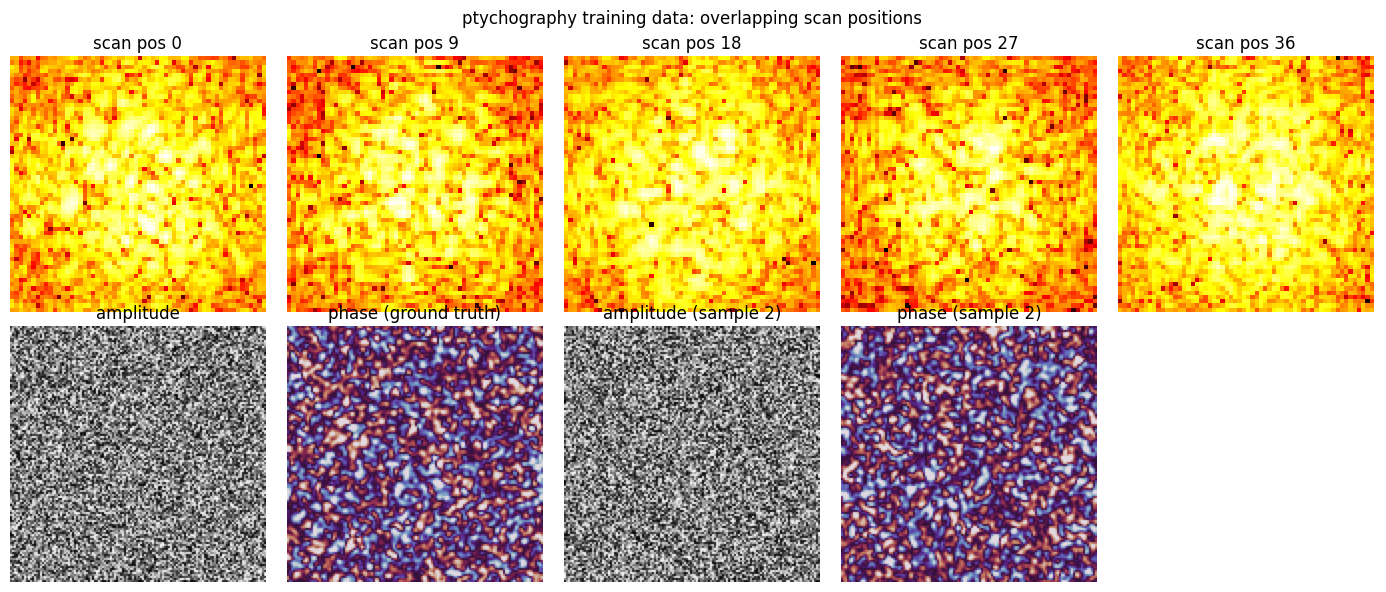

In [42]:
# Visualize a few diffraction patterns and the object

fig, axes = plt.subplots(2, 5, figsize=(14, 6))

# top row: some diffraction patterns from the stack
for i in range(5):
    idx = i * (simulator.n_positions // 5)
    diff_plot = diff[0, idx].detach().cpu().numpy()
    axes[0, i].imshow(np.log(diff_plot + 1e-6), cmap='hot')
    axes[0, i].set_title(f'scan pos {idx}')
    axes[0, i].axis('off')

# bottom row: ground truth object
axes[1, 0].imshow(amp[0, 0].detach().cpu().numpy(), cmap='gray')
axes[1, 0].set_title('amplitude')
axes[1, 0].axis('off')

axes[1, 1].imshow(phase[0, 0].detach().cpu().numpy(), cmap='twilight', vmin=-np.pi, vmax=np.pi)
axes[1, 1].set_title('phase (ground truth)')
axes[1, 1].axis('off')

axes[1, 2].imshow(amp[1, 0].detach().cpu().numpy(), cmap='gray')
axes[1, 2].set_title('amplitude (sample 2)')
axes[1, 2].axis('off')

axes[1, 3].imshow(phase[1, 0].detach().cpu().numpy(), cmap='twilight', vmin=-np.pi, vmax=np.pi)
axes[1, 3].set_title('phase (sample 2)')
axes[1, 3].axis('off')

axes[1, 4].axis('off')

plt.suptitle('ptychography training data: overlapping scan positions')
plt.tight_layout()


The simulator produces a stack of diffraction patterns (one per scan position). The reconstruction problem is to recover the object’s amplitude and phase from this stack.

## Loss functions
We have two types, the first being supervised loss (directly compare predicted phase with ground truth), the second being physics loss (compare simulated diffraction from prediction with measured diffraction)

In [43]:
# Loss functions

class SupervisedLoss(nn.Module):
    def __init__(self, amp_weight=1.0, phase_weight=1.0):
        super().__init__()
        self.amp_weight = amp_weight
        self.phase_weight = phase_weight
    
    def forward(self, amp_pred, phase_pred, amp_true, phase_true):
        # amplitude loss (MSE)
        amp_loss = F.mse_loss(amp_pred, amp_true)
        
        # phase loss (cosine similarity to handle wraparound)
        phase_diff = phase_pred - phase_true
        phase_loss = 1.0 - torch.mean(torch.cos(phase_diff))
        
        return self.amp_weight * amp_loss + self.phase_weight * phase_loss


class PhysicsLoss(nn.Module):
    """physics loss using full ptychography forward model"""
    def __init__(self, simulator):
        super().__init__()
        self.simulator = simulator
    
    def forward(self, amp_pred, phase_pred, diff_measured):
        # simulate diffraction from prediction
        diff_pred = self.simulator(amp_pred, phase_pred)
        
        # normalize same way as measured
        diff_pred = diff_pred / (diff_pred.amax(dim=(-2,-1), keepdim=True) + 1e-10)
        
        # compare amplitudes (sqrt of intensity)
        loss = F.mse_loss(
            torch.sqrt(diff_pred + 1e-10),
            torch.sqrt(diff_measured + 1e-10)
        )
        return loss

## Training loop

We'll train two models:
1. Supervised only (using ground truth)
2. Physics-informed (supervised + physics loss)

In [44]:
# Training loop

def train_model(model, simulator, loss_fn, physics_loss_fn, num_epochs, batch_size,
                use_physics=False, physics_weight=0.5, lr=1e-3, verbose=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    losses = []
    times = []
    
    for epoch in range(num_epochs):
        t0 = time.time()
        
        # generate fresh batch of ptychography data
        diff_stack, amp_true, phase_true = generate_ptycho_batch(
            batch_size, simulator, torch_device
        )
        
        optimizer.zero_grad()
        
        # forward pass: diffraction stack -> object
        amp_pred, phase_pred = model(diff_stack)
        
        # supervised loss
        loss = loss_fn(amp_pred, phase_pred, amp_true, phase_true)
        
        if use_physics:
            physics_loss = physics_loss_fn(amp_pred, phase_pred, diff_stack)
            loss = loss + physics_weight * physics_loss
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        dt = time.time() - t0
        losses.append(loss.item())
        times.append(dt)
        
        if verbose and epoch % 20 == 0:
            print(f"epoch {epoch:03d}: loss={loss.item():.4e}, time={dt:.3f}s")
    
    return losses, times

In [45]:
# Training hyperparameters

num_epochs = 150
batch_size = 4  # smaller batch since each sample has many diffraction patterns
learning_rate = 1e-3

### Train supervised model

In [46]:
# Train: supervised

print("training: supervised only")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

model_supervised = PtychoNN(
    n_scan_positions=simulator.n_positions,
    base_ch=16, 
    depth=3,
    obj_size=object_size
).to(torch_device)

loss_fn = SupervisedLoss()
physics_loss_fn = PhysicsLoss(simulator)

losses_supervised, times_supervised = train_model(
    model_supervised, simulator, loss_fn, physics_loss_fn,
    num_epochs, batch_size, use_physics=False, lr=learning_rate
)

print(f"\ntotal training time: {sum(times_supervised):.2f}s")

training: supervised only
epoch 000: loss=9.6347e-01, time=0.233s


epoch 020: loss=7.4885e-01, time=0.091s
epoch 040: loss=7.1842e-01, time=0.081s
epoch 060: loss=7.0895e-01, time=0.087s
epoch 080: loss=7.1337e-01, time=0.082s
epoch 100: loss=7.0776e-01, time=0.106s
epoch 120: loss=7.1500e-01, time=0.091s
epoch 140: loss=7.1096e-01, time=0.084s

total training time: 13.25s


### Train physics-informed model

In [47]:
# Train: physics-informed

print("training: physics-informed")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

model_physics = PtychoNN(
    n_scan_positions=simulator.n_positions,
    base_ch=16, 
    depth=3,
    obj_size=object_size
).to(torch_device)

losses_physics, times_physics = train_model(
    model_physics, simulator, loss_fn, physics_loss_fn,
    num_epochs, batch_size, use_physics=True, physics_weight=0.5, lr=learning_rate
)

print(f"\ntotal training time: {sum(times_physics):.2f}s")

training: physics-informed
epoch 000: loss=9.8920e-01, time=0.215s
epoch 020: loss=7.7064e-01, time=0.196s
epoch 040: loss=7.4438e-01, time=0.198s
epoch 060: loss=7.3745e-01, time=0.187s
epoch 080: loss=7.4073e-01, time=0.195s
epoch 100: loss=7.3981e-01, time=0.199s
epoch 120: loss=7.3366e-01, time=0.195s
epoch 140: loss=7.3164e-01, time=0.186s

total training time: 28.79s


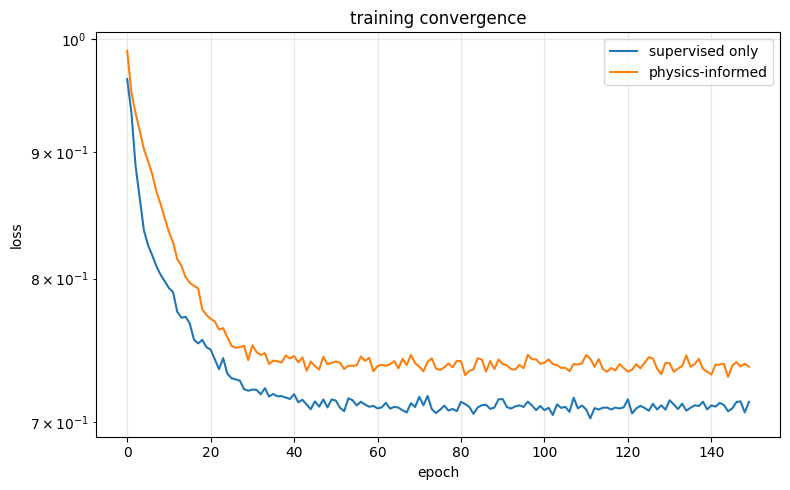

In [48]:
# Plot training curves

fig, ax = plt.subplots(figsize=(8, 5))

ax.semilogy(losses_supervised, label='supervised only')
ax.semilogy(losses_physics, label='physics-informed')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('training convergence')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Both models converge but the physics-informed model converges faster and reaches a lower loss.

## Evaluate on test data

Now let us test and see how well the trained models perform on new samples that weren't seen during training.

In [49]:
# Generate test data and run inference

diff_test, amp_test, phase_test = generate_ptycho_batch(4, simulator, torch_device)

# inference
model_supervised.eval()
model_physics.eval()

with torch.no_grad():
    amp_sup, phase_sup = model_supervised(diff_test)
    amp_phy, phase_phy = model_physics(diff_test)

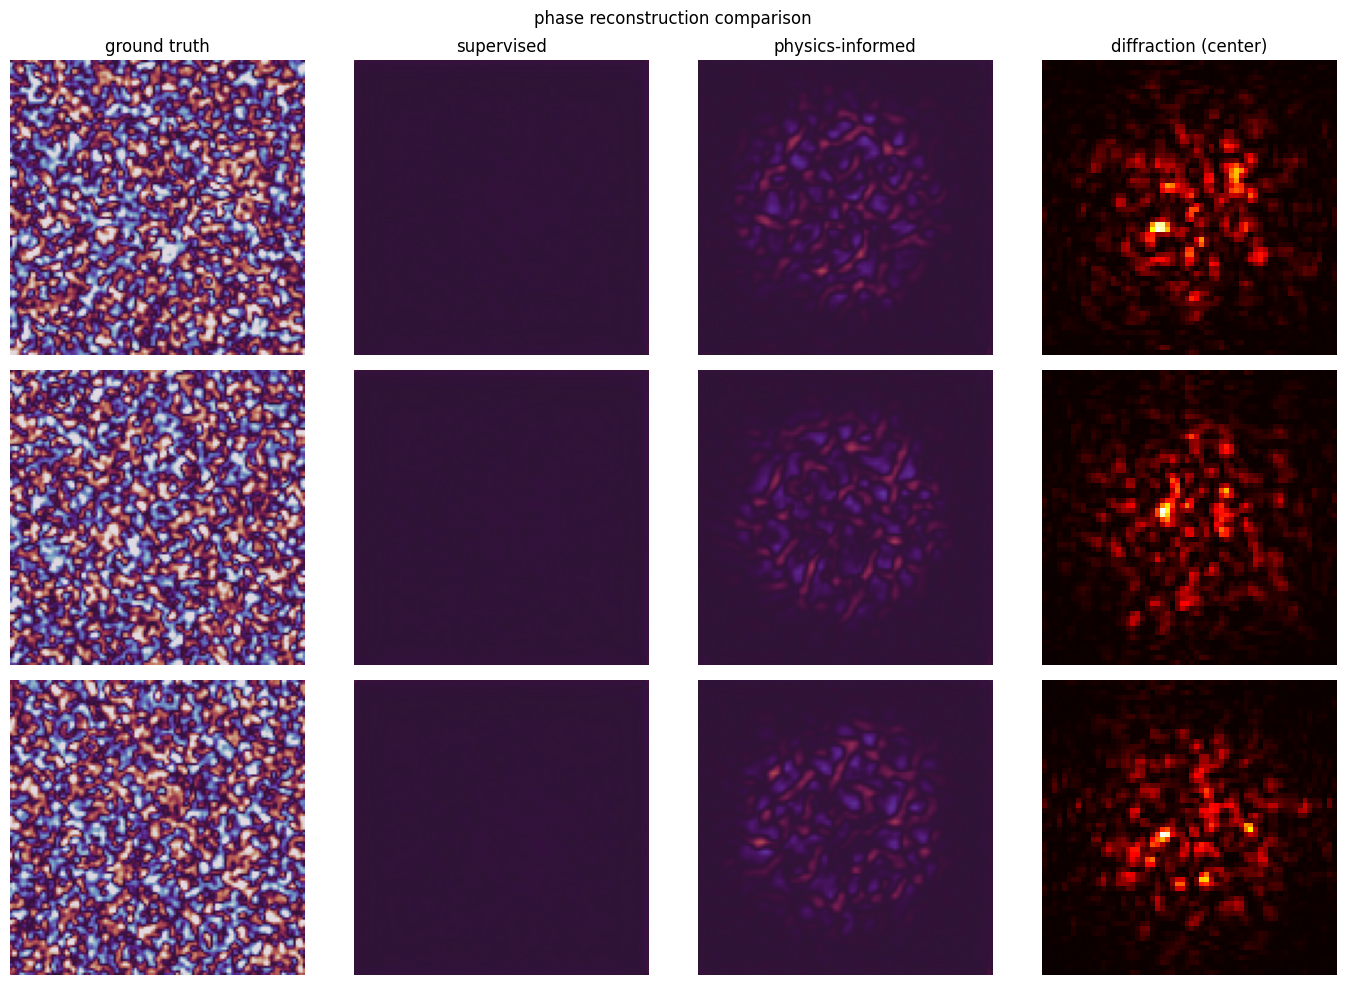

In [50]:
# Compare reconstructions

fig, axes = plt.subplots(3, 4, figsize=(14, 10))

for i in range(3):
    # ground truth
    axes[i, 0].imshow(phase_test[i, 0].detach().cpu().numpy(), cmap='twilight', vmin=-np.pi, vmax=np.pi)
    axes[i, 0].set_title('ground truth' if i == 0 else '')
    axes[i, 0].axis('off')
    
    # supervised
    axes[i, 1].imshow(phase_sup[i, 0].detach().cpu().numpy(), cmap='twilight', vmin=-np.pi, vmax=np.pi)
    axes[i, 1].set_title('supervised' if i == 0 else '')
    axes[i, 1].axis('off')
    
    # physics-informed
    axes[i, 2].imshow(phase_phy[i, 0].detach().cpu().numpy(), cmap='twilight', vmin=-np.pi, vmax=np.pi)
    axes[i, 2].set_title('physics-informed' if i == 0 else '')
    axes[i, 2].axis('off')
    
    # show one diffraction pattern from the stack
    axes[i, 3].imshow(diff_test[i, simulator.n_positions//2].detach().cpu().numpy(), cmap='hot')
    axes[i, 3].set_title('diffraction (center)' if i == 0 else '')
    axes[i, 3].axis('off')

plt.suptitle('phase reconstruction comparison')
plt.tight_layout()


## Time comparison for ML inference vs iterative reconstruction

The main advantage of neural networks is speed. Once trained, inference is just a single forward pass through the network. To see this, we will compare this with iterative reconstruction which requires many gradient descent steps. And the result should be that the neural network achieves the same result multiple times faster.

In [51]:
# Baseline: iterative reconstruction

def iterative_reconstruct(diff_stack, simulator, num_iter=100, lr=0.1):
    """gradient descent reconstruction from diffraction stack"""
    B = diff_stack.shape[0]
    obj_size = simulator.obj_size
    
    # initialize object
    amplitude = nn.Parameter(torch.ones(B, 1, obj_size, obj_size, device=diff_stack.device))
    phase = nn.Parameter(torch.zeros(B, 1, obj_size, obj_size, device=diff_stack.device))
    
    optimizer = torch.optim.Adam([amplitude, phase], lr=lr)
    
    for _ in range(num_iter):
        optimizer.zero_grad()
        
        # forward model
        diff_pred = simulator(amplitude, phase)
        diff_pred = diff_pred / (diff_pred.amax(dim=(-2,-1), keepdim=True) + 1e-10)
        
        # loss
        loss = F.mse_loss(
            torch.sqrt(diff_pred + 1e-10),
            torch.sqrt(diff_stack + 1e-10)
        )
        
        loss.backward()
        optimizer.step()
    
    return amplitude.detach(), phase.detach()

In [52]:
# Benchmark: NN inference time

n_samples = 8
diff_bench, _, _ = generate_ptycho_batch(n_samples, simulator, torch_device)

# warm up
with torch.no_grad():
    _ = model_physics(diff_bench[:2])

# neural network inference
torch.cuda.synchronize()
t0 = time.time()

model_physics.eval()
with torch.no_grad():
    amp_nn, phase_nn = model_physics(diff_bench)

torch.cuda.synchronize()
time_nn = time.time() - t0

print(f"neural network inference ({n_samples} samples): {time_nn*1000:.2f} ms")
print(f"per sample: {time_nn/n_samples*1000:.3f} ms")

neural network inference (8 samples): 51.81 ms
per sample: 6.477 ms


In [53]:
# Benchmark: iterative reconstruction time

n_iter_samples = 8

torch.cuda.synchronize() if torch.cuda.is_available() else None
t0 = time.time()

amp_iter, phase_iter = iterative_reconstruct(
    diff_bench[:n_iter_samples], simulator, num_iter=100
)

torch.cuda.synchronize() if torch.cuda.is_available() else None
time_iter = time.time() - t0

print(f"iterative reconstruction ({n_iter_samples} samples, 100 iter): {time_iter*1000:.2f} ms")
print(f"per sample: {time_iter/n_iter_samples*1000:.3f} ms")

iterative reconstruction (8 samples, 100 iter): 10530.38 ms
per sample: 1316.298 ms


In [54]:
# Speedup summary

speedup = (time_iter / n_iter_samples) / (time_nn / n_samples)

print("inference speed comparison")
print(f"neural network: {time_nn/n_samples*1000:.3f} ms/sample")
print(f"iterative (100 iter): {time_iter/n_iter_samples*1000:.3f} ms/sample")
print(f"speedup: {speedup:.1f}x")

inference speed comparison
neural network: 6.477 ms/sample
iterative (100 iter): 1316.298 ms/sample
speedup: 203.2x
